## Vertex AI MLOps Book - Chapter 8 - Explainable AI - Example Based explanations

In [14]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [15]:
#Reference: 
#This notebook is based on sample notebook published in Google Cloud Platform Vertex AI Community notebook repository. 
#Link - https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/gapic/custom/showcase_custom_image_classification_online_explain_example_based_api.ipynb

### Important Note: 
This notebook might deploy and consume cloud resources in your Google Cloud Project(s) leading to you getting charged/billed for those resources. It's your respondibility to verify the impact of this code before you run it and to monitor and delete any resources to avoid ongoing cloud charges. 

## Overview

This notebook demonstrates how to get example-based explanations for your model. Explanations can help you answer questions about why a model made a certain prediction, relating it to the features in the training data. In this demo we will go over:

1. Getting Example-Based explanations from Vertex Explainable AI services.
2. A use-case for exploring similar examples to understand model predictions.



### Dataset

For this notebook, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/) downloaded through [TF Datasets](https://www.tensorflow.org/datasets/catalog/stl10). This dataset is a subset of the [ImageNet dataset](https://www.image-net.org/) with just 10 classes.

### Objective

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Training`
- `Vertex Explainable AI`
- `Vertex AI Prediction`
- `Vertex AI Model`

The steps performed include:

1. Prepare training data
2. Fine tune a image classication model to get embeddings
3. Register the model in Vertex AI Model Registry
4. Deploy the model in Vertex AI Endpoint
5. Request explanations using Example-Based Explanation API
6. Analyze the results

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installations

Install the following packages to execute this notebook.

In [16]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

if os.getenv("IS_TESTING"):
    ! pip3 install {USER_FLAG} --upgrade numpy tensorflow tensorflow_datasets -q
    ! pip3 install {USER_FLAG} --upgrade google-cloud-aiplatform -q
else:
    ! pip3 install {USER_FLAG} --upgrade numpy==1.21.6 tensorflow==2.8.0 tensorflow_datasets==4.6.0 -q
    ! pip3 install {USER_FLAG} --upgrade google-cloud-aiplatform==1.15.0 -q

### Restart the kernel

After you install/upgrade the packages, you need to restart the notebook kernel so it can find those packages.

In [17]:
# Automatically restart kernel after installs
if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
import os

PROJECT_ID = "Enter_Your_Project_Name"

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  jsb-alto


In [2]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Get your project number 

Now that the project ID is set, you get your corresponding project number.

In [3]:
shell_output = ! gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = shell_output[0]
print("Project Number:", PROJECT_NUMBER)

Project Number: 398507275014


### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type:"string"}

if REGION == "[your-region]":
    REGION = "us-central1"  # @param {type: "string"}

### Timestamp



In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks, you will skip this step**, since your environment is already
authenticated.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.



In [6]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import sys

# If on Vertex AI Workbench, then don't execute this code

IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket



In [7]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "-aip-" + TIMESTAMP
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Run the following cell to create your Cloud Storage bucket.** If the bucket already exists, you will get an error but it wouldn't affect the rest of the tutorial. However, you might get unwanted data in this bucket.

In [9]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://jsb-alto-aip-20231017072856/...


Finally, validate access to your Cloud Storage bucket by examining its contents. If this is a new bucket, this cell wouldn't produce an output.

In [10]:
! gsutil ls -al $BUCKET_URI

### Get your service account 

If you do not want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [11]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [12]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 398507275014-compute@developer.gserviceaccount.com


### Set service account access 

Run the following commands to grant your service account access to the bucket that you created in the previous step. You only need to run this step once per service account.

In [13]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator {BUCKET_URI}

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer {BUCKET_URI}

### Create local directories
Next, you create some local directories that you use in this tutorial.

In [14]:
DATA_PATH = "data"
DELIVERABLE_PATH = "deliverables"

! mkdir -m 777 -p {DATA_PATH}
! mkdir -m 777 -p {DELIVERABLE_PATH}

### Import libraries

In [15]:
import base64
import io
import json
# General
import time

# Training
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
# Vertex AI
from google.cloud import aiplatform_v1beta1 as vertex_ai_v1beta1
from google.cloud.aiplatform_v1beta1.types import io as io_pb2
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

### Set up variables

#### Set Tutorial variables

Set some variables for the tutorial.

In [16]:
# General
ENVIRON = "prod"
DATASET_NAME = (
    "stl10"  # Will be downloaded from https://www.tensorflow.org/datasets/catalog/stl10
)

# Model experimentation
RAW_DIR = f"{DATA_PATH}/raw/{DATASET_NAME}"
PREPROCESSED_DIR = f"{DATA_PATH}/preprocessed/{DATASET_NAME}"
MODEL_DIR = f"{DELIVERABLE_PATH}/models/mobilenetv2-{DATASET_NAME}"

#### Set Vertex AI constants

Setup up the following constants for Vertex:

- `API_ENDPOINT`: The Vertex API service endpoint for dataset, model, job, pipeline and endpoint services.
- `PARENT`: The Vertex location root path for dataset, model, job, pipeline and endpoint resources.

In [17]:
# API service endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# Vertex location root path for your dataset, model and endpoint resources
PARENT = "projects/" + PROJECT_ID + "/locations/" + REGION

#### Set hardware accelerators

Set the hardware accelerators (e.g., GPU), if any, for training and prediction.

Set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Telsa K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

For GPU, available accelerators include:
   - aip.AcceleratorType.NVIDIA_TESLA_K80
   - aip.AcceleratorType.NVIDIA_TESLA_P100
   - aip.AcceleratorType.NVIDIA_TESLA_P4
   - aip.AcceleratorType.NVIDIA_TESLA_T4
   - aip.AcceleratorType.NVIDIA_TESLA_V100


Otherwise specify `(None, None)` to use a container image to run on a CPU.

*Note*: TF releases before 2.3 for GPU support will fail to load the custom model in this tutorial. It is a known issue and fixed in TF 2.3 -- which is caused by static graph ops that are generated in the serving function. If you encounter this issue on your own custom models, use a container image for TF 2.3 with GPU support.

In [18]:
if os.getenv("IS_TESTING_TRAIN_GPU"):
    TRAIN_GPU, TRAIN_NGPU = (
        vertex_ai_v1beta1.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_TRAIN_GPU")),
    )
else:
    TRAIN_GPU, TRAIN_NGPU = (vertex_ai_v1beta1.AcceleratorType.NVIDIA_TESLA_K80, 1)

if os.getenv("IS_TESTING_DEPLOY_GPU"):
    DEPLOY_GPU, DEPLOY_NGPU = (
        vertex_ai_v1beta1.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_DEPLOY_GPU")),
    )
else:
    DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Set pre-built containers

Set the pre-built Docker container image for training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers).

For the latest list, see [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [19]:
if os.getenv("IS_TESTING_TF"):
    TF = os.getenv("IS_TESTING_TF")
else:
    TF = "2-8"

if TF[0] == "2":
    if TRAIN_GPU:
        TRAIN_VERSION = "tf-gpu.{}".format(TF)
    else:
        TRAIN_VERSION = "tf-cpu.{}".format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf2-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf2-cpu.{}".format(TF)
else:
    if TRAIN_GPU:
        TRAIN_VERSION = "tf-gpu.{}".format(TF)
    else:
        TRAIN_VERSION = "tf-cpu.{}".format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf-cpu.{}".format(TF)

TRAIN_IMAGE = "{}-docker.pkg.dev/vertex-ai/training/{}:latest".format(
    REGION.split("-")[0], TRAIN_VERSION
)
DEPLOY_IMAGE = "{}-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(
    REGION.split("-")[0], DEPLOY_VERSION
)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest None None


#### Set machine type

Next, set the machine type to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure  the compute resources for the VMs you will use for for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.

 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [20]:
if os.getenv("IS_TESTING_TRAIN_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_TRAIN_MACHINE")
else:
    MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

if os.getenv("IS_TESTING_DEPLOY_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_DEPLOY_MACHINE")
else:
    MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type n1-standard-4
Deploy machine type n1-standard-4


### Helpers

Below a series of helper functions you use along the tutorial:



1.   `create_index_to_name_map` : Creates a map from index to name for label variables
2.   `extract_images_and_labels` : A function to extract a batch of images and labels from a dataset
3.   `plot_input_and_neighbors` : A function to plot the input image and its neighbors


In [21]:
def create_index_to_name_map(ds_info):
    """
    Creates a map from label name to numerical index.
    Args:
        ds_info: DatasetInfo object.
    Returns:
        index_to_name_map: dict. Map from name to index.
    """
    index_to_name = {}
    num_classes = ds_info.features["label"].num_classes
    names = ds_info.features["label"].names
    for i in range(num_classes):
        index_to_name[i] = names[i]
    return index_to_name


def extract_images_and_labels(ds, num_batches):
    """
    Extract images and labels from a dataset.
    Args:
        ds: A dataset.
        num_batches: The number of batches to extract. -1 uses the whole dataset
    Returns:
        images: A numpy structure of images.
        labels: A numpy structure of labels.
    """
    data_slice = ds.take(num_batches)
    images = []
    labels = []
    for image, label in data_slice:
        images.append(image)
        labels.append(label)
    images = tf.concat(images, 0)
    labels = tf.concat(labels, 0)
    print(f"Image batch shape: {images.shape}")
    return images.numpy(), labels.numpy()


def plot_input_and_neighbors(
    val_img_idx,
    all_train_images,
    val_images,
    all_train_labels,
    val_labels,
    label_index_to_name,
    data_with_neighbors,
):
    """
    Plot the input image and its neighbors.
    Args:
        val_img_idx: Index of the input image.
        all_train_images: All training images.
        val_images: Validation images.
        all_train_labels: All training labels.
        val_labels: Validation labels.
        label_index_to_name: Dictionary mapping label indices to names.
        data_with_neighbors: Data with neighbors.
    Returns:
        None
    """
    image = val_images[val_img_idx]
    fig = plt.figure(figsize=(24, 12))
    ax_list = fig.subplots(3, 5)
    ax_list[0, 0].axis("off")
    ax_list[0, 1].axis("off")
    ax_list[0, 3].axis("off")
    ax_list[0, 4].axis("off")
    ax = ax_list[0, 2]
    class_label = val_labels[val_img_idx]
    ax.set_title(
        f"{class_label}:{label_index_to_name[class_label]} (example index: {val_img_idx})",
        fontsize=15,
    )
    ax.axis("off")
    ax.imshow(image.astype("uint8"))

    neighbor_list = data_with_neighbors[val_img_idx]["neighbors"]
    num_neighbors = len(neighbor_list)
    for n in range(num_neighbors):
        neighbor = neighbor_list[n]
        neighbor_idx = int(neighbor["neighborId"])
        neighbor_dist = neighbor["neighborDistance"]
        ax = ax_list[1 + n // 5, n % 5]
        class_label = all_train_labels[neighbor_idx]
        ax.set_title(
            f"{class_label}:{label_index_to_name[class_label]} (dist: {neighbor_dist:.3f})",
            fontsize=15,
        )
        ax.axis("off")
        ax.imshow(all_train_images[neighbor_idx].astype("uint8"))

# Tutorial

The Vertex Explainable Example-based API provides an highly performant ANN service for returning similar examples to new predictions/instances.

Then, in order to leverage the Example-based explanations service, you need to cover the following steps:

1) Index the entire dataset: You need to provide a path to an embedding model in a GCS bucket, training data stored in a GCS bucket and the config file for example-based explanation 
   
2) Deploy index and model: You need to specify the machine to use and the model identifier from the model upload set

3) Query for similar examples: You need to make the explain query and model will return similar examples

Let's start to experiment a custom model for STL10 dataset you will use to extract embeddings. 

## Experimentation

### Prepare training data

#### Download and visualize the data

Dataset stl10 downloaded and prepared to data/raw/stl10/stl10/1.0.0. Subsequent calls will reuse this data.


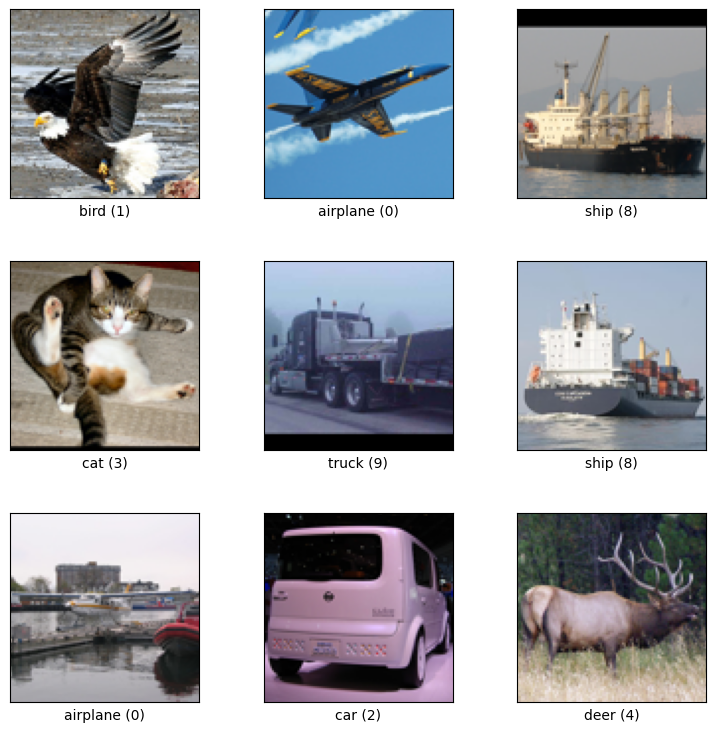

In [23]:
split_ds, ds_info = tfds.load(
    DATASET_NAME,
    split=["train", "test"],
    as_supervised=True,  # Include labels
    with_info=True,
    shuffle_files=False,  # ensuring that the data doesn't get shuffled between runs
    data_dir=RAW_DIR,
)
train_ds, validation_ds = split_ds
tfds.show_examples(ds=train_ds, ds_info=ds_info);

In [24]:
print(f'Number of classes in the dataset: {ds_info.features["label"].num_classes}')
print(f'Label names: {ds_info.features["label"].names}')
print(f'Number of examples in training split: {ds_info.splits["train"].num_examples}')
print(f'Number of examples in validation split: {ds_info.splits["test"].num_examples}')

Number of classes in the dataset: 10
Label names: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number of examples in training split: 5000
Number of examples in validation split: 8000


#### Prepare the images

Scale the images to the size expected by the downstream model


In [25]:
size = (224, 224)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

#### Batch and prefetch data


In [26]:
batch_size = 32

train_ds = train_ds.batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.batch(batch_size).prefetch(buffer_size=10)

In [27]:
label_index_to_name = create_index_to_name_map(ds_info)
print(label_index_to_name)

{0: 'airplane', 1: 'bird', 2: 'car', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'horse', 7: 'monkey', 8: 'ship', 9: 'truck'}


### Create and train the model

#### Fine-tune the last layer of a pre-trained classification model

You use a `MobileNetV2` [Keras Application](https://keras.io/api/applications/) deep learning model that is available alongside pre-trained weights for fine-tuning the model which will be used to create embeddings.

In [28]:
# Each image can be flipped and rotated to generate more training data, and
# ensure the model is more robust to such changes, since a rotated "bird" should
# still be classified as a bird.

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [29]:
size_3d = (224, 224, 3)
num_classes = ds_info.features["label"].num_classes

# Load an ImageNet model.
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=size_3d,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=size_3d)
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean**2

# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var, 0])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                         

You can improve the latent representation of the pre-trained model by unfreezing the lower layers and fine-tuning. However, you forego that step in this demo so that the learned representations are exactly the same as the pre-trained model, and only the softmax layer is trained briefly.

In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

epochs = 2
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
157/157 [==============================] - 25s 103ms/step - loss: 0.7103 - sparse_categorical_accuracy: 0.7802 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9361
Epoch 2/2
157/157 [==============================] - 15s 98ms/step - loss: 0.3018 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.1977 - val_sparse_categorical_accuracy: 0.9399


### Evaluate the model

Plot the `accurancy` and the `loss` of the model after training

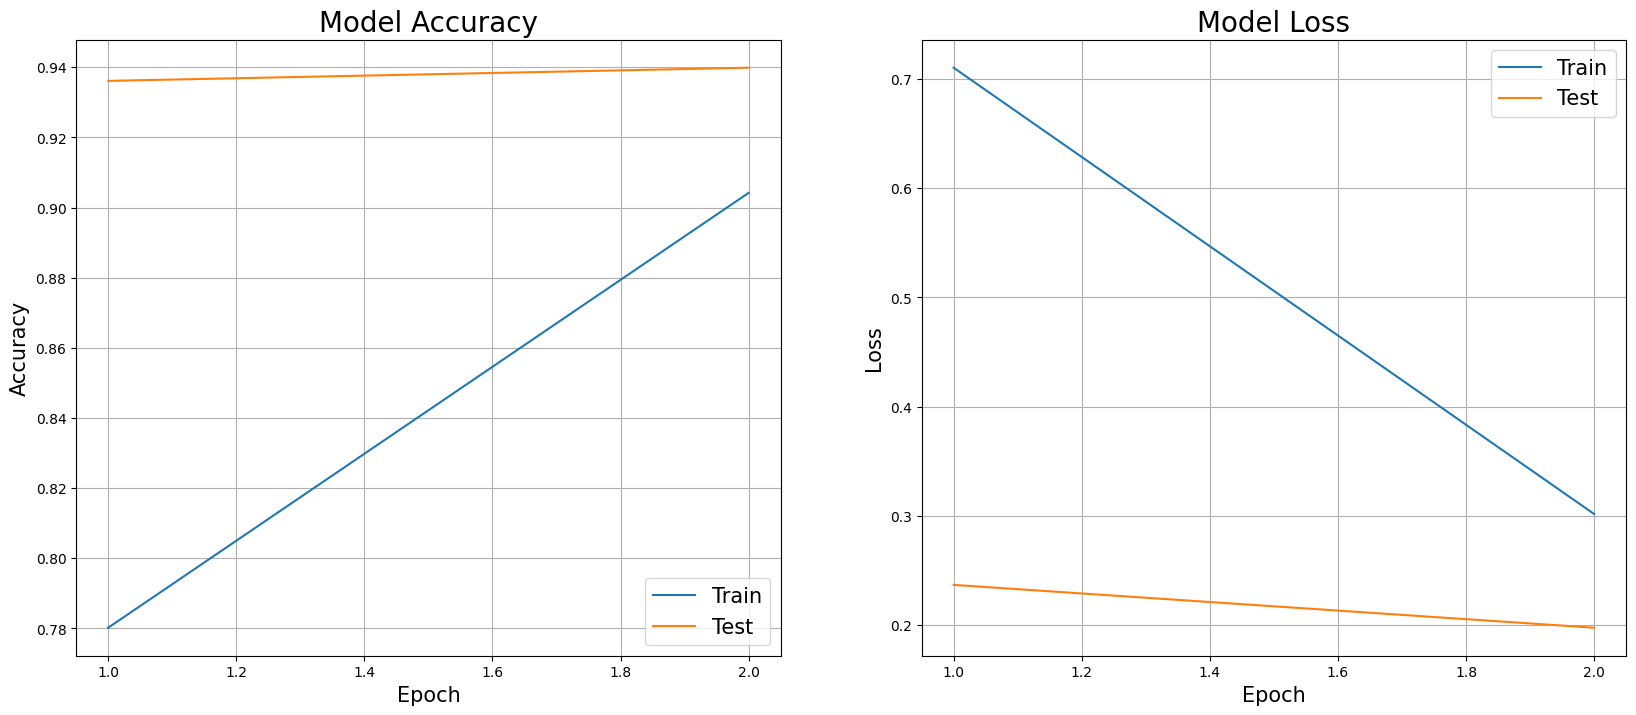

In [31]:
x_axis = range(1, epochs + 1)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_axis, history.history["sparse_categorical_accuracy"])
plt.plot(x_axis, history.history["val_sparse_categorical_accuracy"])
plt.title("Model Accuracy", fontsize=20)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.legend(["Train", "Test"], fontsize=15)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_axis, history.history["loss"])
plt.plot(x_axis, history.history["val_loss"])
plt.title("Model Loss", fontsize=20)
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.legend(["Train", "Test"], fontsize=15)
plt.grid();

## Formalization

Now that you experiment the model to create the embeddings, let's formalize the training to leverage Vertex AI.

### Set up clients

The Vertex AI client library works as a client/server model. Then you need to set clients to use different services.

You will use different clients in this tutorial for different steps in the workflow. So set them all up upfront.

- Model Service for `Model` resources.
- Endpoint Service for deployment.
- Job Service for batch jobs and custom training.
- Prediction Service for serving.

In [32]:
# client options same for all services
client_options = {"api_endpoint": API_ENDPOINT}


def create_job_client():
    client = vertex_ai_v1beta1.JobServiceClient(client_options=client_options)
    return client


def create_model_client():
    client = vertex_ai_v1beta1.ModelServiceClient(client_options=client_options)
    return client


def create_endpoint_client():
    client = vertex_ai_v1beta1.EndpointServiceClient(client_options=client_options)
    return client


def create_prediction_client():
    client = vertex_ai_v1beta1.PredictionServiceClient(client_options=client_options)
    return client


clients = {}
clients["job"] = create_job_client()
clients["model"] = create_model_client()
clients["endpoint"] = create_endpoint_client()
clients["prediction"] = create_prediction_client()

for client in clients.items():
    print(client)

('job', <google.cloud.aiplatform_v1beta1.services.job_service.client.JobServiceClient object at 0x7f48546ac700>)
('model', <google.cloud.aiplatform_v1beta1.services.model_service.client.ModelServiceClient object at 0x7f48546aec20>)
('endpoint', <google.cloud.aiplatform_v1beta1.services.endpoint_service.client.EndpointServiceClient object at 0x7f48546ad9f0>)
('prediction', <google.cloud.aiplatform_v1beta1.services.prediction_service.client.PredictionServiceClient object at 0x7f48546ad570>)


### Train a model

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.

### Prepare your custom job specification

Now that your clients are ready, your first step is to create a Job Specification for your custom training job. The job specification will consist of the following:

- `worker_pool_spec` : The specification of the type of machine(s) you will use for training and how many (single or distributed)
- `python_package_spec` : The specification of the Python package to be installed with the pre-built container.

#### Prepare your machine specification

Now define the machine specification for your custom training job. This tells Vertex AI what type of machine instance to provision for the training.
  - `machine_type`: The type of GCP instance to provision -- e.g., n1-standard-8.
  - `accelerator_type`: The type, if any, of hardware accelerator. In this tutorial if you previously set the variable `TRAIN_GPU != None`, you are using a GPU; otherwise you will use a CPU.
  - `accelerator_count`: The number of accelerators.

In [33]:
if TRAIN_GPU:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_type": TRAIN_GPU,
        "accelerator_count": TRAIN_NGPU,
    }
else:
    machine_spec = {"machine_type": TRAIN_COMPUTE, "accelerator_count": 0}

#### Prepare your disk specification

(optional) Now define the disk specification for your custom training job. This tells Vertex what type and size of disk to provision in each machine instance for the training.

  - `boot_disk_type`: Either SSD or Standard. SSD is faster, and Standard is less expensive. Defaults to SSD.
  - `boot_disk_size_gb`: Size of disk in GB.

In [34]:
DISK_TYPE = "pd-ssd"  # [ pd-ssd, pd-standard]
DISK_SIZE = 200  # GB

disk_spec = {"boot_disk_type": DISK_TYPE, "boot_disk_size_gb": DISK_SIZE}

#### Define the worker pool specification

Next, you define the worker pool specification for your custom training job. The worker pool specification will consist of the following:

- `replica_count`: The number of instances to provision of this machine type.
- `machine_spec`: The hardware specification.
- `disk_spec` : (optional) The disk storage specification.

- `python_package`: The Python training package to install on the VM instance(s) and which Python module to invoke, along with command line arguments for the Python module.

Let's dive deeper now into the python package specification:

-`executor_image_spec`: This is the docker image which is configured for your custom training job.

-`package_uris`: This is a list of the locations (URIs) of your python training packages to install on the provisioned instance. The locations need to be in a Cloud Storage bucket. These can be either individual python files or a zip (archive) of an entire package. In the later case, the job service will unzip (unarchive) the contents into the docker image.

-`python_module`: The Python module (script) to invoke for running the custom training job. In this example, you will be invoking `trainer.task.py` -- note that it was not neccessary to append the `.py` suffix.

-`args`: The command line arguments to pass to the corresponding Pythom module. In this example, you will be setting:
  - `"--model-dir=" + MODEL_URI` : The Cloud Storage location where to store the model artifacts. There are two ways to tell the training script where to save the model artifacts:
      - direct: You pass the Cloud Storage location as a command line argument to your training script (set variable `DIRECT = True`), or
      - indirect: The service passes the Cloud Storage location as the environment variable `AIP_MODEL_DIR` to your training script (set variable `DIRECT = False`). In this case, you tell the service the model artifact location in the job specification.
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--distribute=" + TRAIN_STRATEGY"` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

In [35]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_URI = f"{BUCKET_URI}/{DELIVERABLE_PATH}/models/mobilenetv2-{DATASET_NAME}"

if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"

EPOCHS = 2

DIRECT = True
if DIRECT:
    CMDARGS = [
        "--model-dir=" + MODEL_URI,
        "--epochs=" + str(EPOCHS),
        "--distribute=" + TRAIN_STRATEGY,
    ]
else:
    CMDARGS = [
        "--epochs=" + str(EPOCHS),
        "--distribute=" + TRAIN_STRATEGY,
    ]

worker_pool_spec = [
    {
        "replica_count": 1,
        "machine_spec": machine_spec,
        "disk_spec": disk_spec,
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [BUCKET_URI + "/trainer_stl10.tar.gz"],
            "python_module": "trainer.task",
            "args": CMDARGS,
        },
    }
]

### Assemble a job specification

Now assemble the complete description for the custom job specification:

- `display_name`: The human readable name you assign to this custom job.
- `job_spec`: The specification for the custom job.
    - `worker_pool_specs`: The specification for the machine VM instances.
    - `base_output_directory`: This tells the service the Cloud Storage location where to save the model artifacts (when variable `DIRECT = False`). The service will then pass the location to the training script as the environment variable `AIP_MODEL_DIR`, and the path will be of the form:

                <output_uri_prefix>/model

In [36]:
if DIRECT:
    job_spec = {"worker_pool_specs": worker_pool_spec}
else:
    job_spec = {
        "worker_pool_specs": worker_pool_spec,
        "base_output_directory": {"output_uri_prefix": MODEL_DIR},
    }

custom_job = {"display_name": JOB_NAME, "job_spec": job_spec}

### Examine the training package

#### Package layout

Before you start the training, you will look at how a Python package is assembled for a custom training job. When unarchived, the package contains the following directory/file layout.

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the Docker image.

The file `trainer/task.py` is the Python script for executing the custom training job. *Note*, when we referred to it in the worker pool specification, we replace the directory slash with a dot (`trainer.task`) and dropped the file suffix (`.py`).

#### Package Assembly

In the following cells, you will assemble the training package.

In [37]:
# Make folder for Python training script
! rm -rf custom
! mkdir custom

# Add package information
! touch custom/README.md

setup_cfg = "[egg_info]\n\ntag_build =\n\ntag_date = 0"
! echo "$setup_cfg" > custom/setup.cfg

setup_py = "import setuptools\n\nsetuptools.setup(\n\n    install_requires=[\n\n        'tensorflow_datasets==4.0.1',\n\n    ],\n\n    packages=setuptools.find_packages())"
! echo "$setup_py" > custom/setup.py

pkg_info = "Metadata-Version: 1.0\n\nName: STL10 image classification\n\nVersion: 0.0.0\n\nSummary: Demonstration training script\n\nHome-page: www.google.com\n\nAuthor: Google\n\nAuthor-email: googler@google.com\n\nLicense: Public\n\nDescription: Demo\n\nPlatform: Vertex"
! echo "$pkg_info" > custom/PKG-INFO

# Make the training subfolder
! mkdir custom/trainer
! touch custom/trainer/__init__.py

#### Create the task script

In the next cell, you write the contents of the training script task.py. We won't go into detail, it's just there for you to browse. In summary:

- Get the directory where to save the model artifacts from the command line (`--model_dir`), and if not specified, then from the environment variable `AIP_MODEL_DIR`.
- Loads STL10 dataset from TF Datasets (tfds).
- Builds a model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs`
- Saves the trained model (`save(args.model_dir)`) to the specified model directory.

In [38]:
%%writefile custom/trainer/task.py
# Single, Mirror and Multi-Machine Distributed Training for STL10

# General
import os
import argparse
import sys
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

# Training
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.client import device_lib

tfds.disable_progress_bar()
from tensorflow import keras
from tensorflow.keras import layers

# Variables
N_CLASSES = 10
SIZE = (224, 224)
BUFFER_SIZE = 10
BATCH_SIZE = 32
SIZE_3D = (224, 224, 3)


# Helpers
# Get arguments
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model-dir', dest='model_dir',
                        default=os.getenv("AIP_MODEL_DIR"), type=str, help='Model dir.')
    parser.add_argument('--epochs', dest='epochs',
                        default=2, type=int,
                        help='Number of epochs.')
    parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                        help='distributed training strategy')
    args = parser.parse_args()
    return args


# Single Machine, single compute device
def get_strategy(distribute):
    if distribute == 'single':
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        else:
            strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

    # Single Machine, multiple compute device
    elif distribute == 'mirror':
        strategy = tf.distribute.MirroredStrategy()

    # Multiple Machine, multiple compute device
    elif distribute == 'multi':
        strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    return strategy


# Get train and validation datasets
def get_train_val_ds():
    split_ds = tfds.load(
        'stl10',
        split=["train", "test"],
        as_supervised=True,
        shuffle_files=False,
    )
    train_ds, validation_ds = split_ds
    return train_ds, validation_ds


# Get preprocessed dataset
def preprocess_dataset(train_ds, validation_ds):
    train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, SIZE), y))
    validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, SIZE), y))
    return train_ds, validation_ds


# Build the model
def build_and_compile_model():
    # Define data augmentation layers
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )

    # Define base model
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",
        input_shape=SIZE_3D,
        include_top=False,
    )

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=SIZE_3D)
    x = data_augmentation(inputs)

    # Normalize inputs for Pre-trained Xception weights
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    x = norm_layer(x)
    norm_layer.set_weights([mean, var, 0])

    # Set inference mode
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(N_CLASSES)(x)

    # Build the model
    model = keras.Model(inputs, outputs)
    model.summary()

    # Compile the model 
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model


if __name__ == "__main__":

    # Initialize arguments and strategy
    logging.info('Initialize arguments and strategy')
    train_args = get_args()

    # Variables
    strategy = get_strategy(train_args.distribute)
    epochs = train_args.epochs
    model_dir = train_args.model_dir
    n_workers = strategy.num_replicas_in_sync
    global_batch_size = BATCH_SIZE * n_workers

    # Print versions
    logging.info('Python Version = {}'.format(sys.version))
    logging.info('TensorFlow Version = {}'.format(tf.__version__))
    logging.info('Python Version = {}'.format(sys.version))

    # Get TRAIN and VAL datasets
    logging.info('Get train and val datasets')
    train_ds, validation_ds = get_train_val_ds()

    # Preprocess TRAIN and VAL datasets
    logging.info('Get train and val datasets')
    train_ds, validation_ds = preprocess_dataset(train_ds, validation_ds)
    train_ds = train_ds.batch(global_batch_size).prefetch(buffer_size=BUFFER_SIZE)
    validation_ds = validation_ds.batch(global_batch_size).prefetch(buffer_size=BUFFER_SIZE)

    # Train model
    logging.info('Build model')
    with strategy.scope():
        model = build_and_compile_model()

    logging.info('Train model')
    model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
    logging.info(f'Save model in {model_dir}')
    model.save(model_dir)

Writing custom/trainer/task.py


#### Store training script on your Cloud Storage bucket

Next, you package the training folder into a compressed tar ball, and then store it in your Cloud Storage bucket.

In [39]:
! rm -f custom.tar custom.tar.gz
! tar cvf custom.tar custom
! gzip custom.tar
! gsutil cp custom.tar.gz $BUCKET_URI/trainer_stl10.tar.gz

custom/
custom/setup.py
custom/README.md
custom/setup.cfg
custom/PKG-INFO
custom/trainer/
custom/trainer/__init__.py
custom/trainer/task.py
Copying file://custom.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      


### Train the model 


Now start the training of your custom training job on Vertex. Use this helper function `create_custom_job`, which takes the following parameter:

-`custom_job`: The specification for the custom job.

The helper function calls job client service's `create_custom_job` method, with the following parameters:

-`parent`: The Vertex location path to `Dataset`, `Model` and `Endpoint` resources.
-`custom_job`: The specification for the custom job.

You will display a handful of the fields returned in `response` object, with the two that are of most interest are:

`response.name`: The Vertex fully qualified identifier assigned to this custom training job. You save this identifier for using in subsequent steps.

`response.state`: The current state of the custom training job.

In [40]:
def create_custom_job(custom_job):
    response = clients["job"].create_custom_job(parent=PARENT, custom_job=custom_job)
    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response


response = create_custom_job(custom_job)

name: projects/398507275014/locations/us-central1/customJobs/6369225462454943744
display_name: custom_job_20231016042813
state: JobState.JOB_STATE_PENDING
create_time: 2023-10-16 04:37:09.613517+00:00
update_time: 2023-10-16 04:37:09.613517+00:00


Now get the unique identifier for the custom job you created.

In [41]:
# The full unique ID for the custom job
job_id = response.name
# The short numeric ID for the custom job
job_short_id = job_id.split("/")[-1]

print(job_id)

projects/398507275014/locations/us-central1/customJobs/6369225462454943744


### Get information on a custom job

Next, use this helper function `get_custom_job`, which takes the following parameter:

- `name`: The Vertex fully qualified identifier for the custom job.

The helper function calls the job client service's`get_custom_job` method, with the following parameter:

- `name`: The Vertex fully qualified identifier for the custom job.

If you recall, you got the Vertex fully qualified identifier for the custom job in the `response.name` field when you called the `create_custom_job` method, and saved the identifier in the variable `job_id`.

In [42]:
def get_custom_job(name, silent=False):
    response = clients["job"].get_custom_job(name=name)
    if silent:
        return response

    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response


response = get_custom_job(job_id)

name: projects/398507275014/locations/us-central1/customJobs/6369225462454943744
display_name: custom_job_20231016042813
state: JobState.JOB_STATE_PENDING
create_time: 2023-10-16 04:37:09.613517+00:00
update_time: 2023-10-16 04:37:09.613517+00:00


In [43]:
while True:
    response = get_custom_job(job_id, True)
    if response.state != vertex_ai_v1beta1.JobState.JOB_STATE_SUCCEEDED:
        print("Training job has not completed:", response.state)
        model_path_to_deploy = None
        if response.state == vertex_ai_v1beta1.JobState.JOB_STATE_FAILED:
            break
    else:
        if not DIRECT:
            MODEL_DIR = MODEL_DIR + "/model"
        model_path_to_deploy = MODEL_URI
        print("Training Time:", response.update_time - response.create_time)
        break
    time.sleep(60)

print("model_to_deploy:", model_path_to_deploy)

Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training Time: 0:14:22.549532
model_to_deploy: gs://jsb-alto-aip-20231016042813/deliverables/models/mobilenetv2-stl

## Deployment

### Load the saved model

Your model is stored in a TensorFlow SavedModel format in a Cloud Storage bucket. Now load it from the Cloud Storage bucket, and then you can do some things, like evaluate the model, and do a prediction.

To load, you use the TF.Keras `model.load_model()` method passing it the Cloud Storage path where the model is saved -- specified by `MODEL_DIR`.

In [44]:
model = tf.keras.models.load_model(MODEL_URI)

### Prepare the model for serving

Next, you will upload your TF.Keras model from the custom job to Vertex AI `Model` service, which will create a Vertex `Model` resource for your custom model. During upload, you need to define a serving function to convert data to the format your model expects. If you send encoded data to Vertex AI, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

### How does the serving function work

When you send a request to an online prediction server, the request is received by a HTTP server. The HTTP server extracts the prediction request from the HTTP request content body. The extracted prediction request is forwarded to the serving function. For Google pre-built prediction containers, the request content is passed to the serving function as a `tf.string`.

The serving function consists of two parts:

- `preprocessing function`:
  - Converts the input (`tf.string`) to the input shape and data type of the underlying model (dynamic graph).
  - Performs the same preprocessing of the data that was done during training the underlying model -- e.g., normalizing, scaling, etc.
- `post-processing function`:
  - Converts the model output to format expected by the receiving application -- e.q., compresses the output.
  - Packages the output for the the receiving application -- e.g., add headings, make JSON object, etc.

Both the preprocessing and post-processing functions are converted to static graphs which are fused to the model. The output from the underlying model is passed to the post-processing function. The post-processing function passes the converted/packaged output back to the HTTP server. The HTTP server returns the output as the HTTP response content.

One consideration you need to consider when building serving functions for TF.Keras models is that they run as static graphs. That means, you cannot use TF graph operations that require a dynamic graph. If you do, you will get an error during the compile of the serving function which will indicate that you are using an EagerTensor which is not supported.

#### Create serving function for image data

To pass images to the prediction service, you encode the compressed (e.g., JPEG) image bytes into base 64 -- which makes the content safe from modification while transmitting binary data over the network. Since this deployed model expects input data as raw (uncompressed) bytes, you need to ensure that the base 64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is fused to the underlying model (instead of upstream on a CPU).

When you send a prediction or explanation request, the content of the request is base 64 decoded into a Tensorflow string (`tf.string`), which is passed to the serving function (`serving_fn`). The serving function preprocesses the `tf.string` into raw (uncompressed) numpy bytes (`preprocess_fn`) to match the input requirements of the model:
- `io.decode_jpeg`- Decompresses the JPG image which is returned as a Tensorflow tensor with three channels (RGB).
- `image.convert_image_dtype` - Changes integer pixel values to float 32, and rescales pixel data between 0 and 1.
- `image.resize` - Resizes the image to match the input shape for the model.

At this point, the data can be passed to the model (`m_call`).

#### XAI signatures

When the serving function is saved back with the underlying model (`tf.saved_model.save`), you specify the input layer of the serving function as the signature `serving_default`.

For XAI image models, you need to save two additional signatures from the serving function:

- `xai_preprocess`: The preprocessing function in the serving function.
- `xai_model`: The concrete function for calling the model.

In [45]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    """
    The preprocess function.
    Args:
        bytes_input: The input image in bytes.
    Returns:
        The preprocessed image in numpy array.
    """
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(224, 224))
    rescale = tf.cast(resized, tf.float32)
    return rescale


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    """
    Preprocess the input image.
    Args:
        bytes_inputs: A list of raw image bytes.
    Returns:
        A list of preprocessed images.
    """
    decoded_images = tf.nest.map_structure(
        tf.stop_gradient, tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32)
    )
    return {CONCRETE_INPUT: decoded_images}


@tf.function(
    input_signature=[tf.TensorSpec([None], tf.string), tf.TensorSpec([None], tf.string)]
)
def serving_fn(id, bytes_inputs):
    """
    This function is used to serve the embeddings.
    Args:
        id: The id of the input.
        bytes_inputs: The input image.
    Returns:
        The output of the model.
    """
    images = preprocess_fn(bytes_inputs)
    embedding = m_call(**images)
    return {"id": id, "embedding": embedding}

#### Extract and upload the embedding model for index creation

As we mentioned above, you need to provide embeddings in order to index the dataset. In this case, you skip the data augmentation layer and drop the softmax layer to get to the embeddings from the model you previously trained. 

In [46]:
embedding_model = keras.Sequential()
for layer in model.layers[:-1]:  # go through until last layer
    print(layer.name)
    if "sequential" not in layer.name:  # skip data augmentation layer
        embedding_model.add(layer)
embedding_model.summary()
probability_model = keras.Sequential([model, tf.keras.layers.Softmax()])

input_2
sequential
normalization
mobilenetv2_1.00_224
global_average_pooling2d
dropout
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
Total params: 2,257,991
Trainable

In [47]:
EMBEDDINGS_URI = (
    f"{BUCKET_URI}/{DELIVERABLE_PATH}/embeddings/mobilenetv2-{DATASET_NAME}"
)

m_call = tf.function(embedding_model.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(
    embedding_model,
    EMBEDDINGS_URI,
    signatures={
        "serving_default": serving_fn,
    },
)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead
2023-10-16 04:52:27.569403: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://jsb-alto-aip-20231016042813/deliverables/embeddings/mobilenetv2-stl10/assets


INFO:tensorflow:Assets written to: gs://jsb-alto-aip-20231016042813/deliverables/embeddings/mobilenetv2-stl10/assets


### Get the serving function signature

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

When making a prediction request, you need to route the request to the serving function instead of the model, so you need to know the input layer name of the serving function -- which you will use later when you make a prediction request.

You also need to know the name of the serving function's input and output layer for constructing the explanation metadata -- which is discussed subsequently.

In [48]:
embedding_model_loaded = tf.saved_model.load(EMBEDDINGS_URI)

serving_input = list(
    embedding_model_loaded.signatures["serving_default"]
    .structured_input_signature[1]
    .keys()
)[0]
print("Serving function input:", serving_input)
serving_output = list(
    embedding_model_loaded.signatures["serving_default"].structured_outputs.keys()
)[0]
print("Serving function output:", serving_output)

input_name = model.input.name
print("Model input name:", input_name)
output_name = model.output.name
print("Model output name:", output_name)

Serving function input: id
Serving function output: id
Model input name: input_2
Model output name: dense/BiasAdd:0


### Upload the training data

Next step is uploading the training data. The explanations are picked from this data. You can choose a smaller number of batches for a faster run but the results would be less precise.

In [ ]:
if not os.path.exists(PREPROCESSED_DIR):
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)

dataset_file = f"{DATASET_NAME}-train-images.jsonl"
saved_jsonl_path = f"{PREPROCESSED_DIR}/{dataset_file}"
input_tensor_name = "bytes_inputs"  # Must match the serving_fn definition

num_batches = -1  # uses the entire dataset
start = time.time()
all_train_images, all_train_labels = extract_images_and_labels(
    train_ds, num_batches=num_batches
)
end = time.time()
print(f"Time taken to process training data: {end - start:.5f} secs")

Image batch shape: (5000, 224, 224, 3)


2023-10-16 04:52:50.761828: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.


In [ ]:
start = time.time()
with open(saved_jsonl_path, "w") as f:
    for i, im in enumerate(all_train_images):
        img_bytes = io.BytesIO()
        image = Image.fromarray(im.astype(np.uint8))
        image.save(img_bytes, format="PNG")
        json.dump(
            {
                "id": str(i),
                "bytes_inputs": {
                    "b64": base64.b64encode(img_bytes.getvalue()).decode("utf-8")
                },
            },
            f,
        )
        f.write("\n")
! gsutil -m cp {saved_jsonl_path} {BUCKET_URI}
end = time.time()
print(f"Time taken to create and upload the training data: {end - start:.5f} secs")

### Example-based explanation specification

Finally, you need to define the example-based explanation. To get explanations when doing a prediction, you must enable the explanation capability and set corresponding settings when you upload your custom model to an Vertex `Model` resource. These settings are referred to as the explanation metadata, which consists of:

- `parameters`: This is the specification for the explainability algorithm to use for explanations on your model. In this tutorial, you will use `Examples`

- `metadata`: This is the specification for how the algoithm is applied on your custom model.

#### Explanation Parameters

Let's first dive deeper into the settings for the explainability algorithm.

#### Example-Based

Example-based explanations enables analogy based explanations for data with applications in error analysis, model debugging, and batch labeling of new data. In turn, this can lead to more accurate and robust models, and efficient data labeling pipelines.


Parameters:

- `examples`: This paramenters allows to define conditions to return the nearest
neighbors from the provided dataset.

With Example-based explanations, you have a new explanation method with associated parameter configuration. Below you have the list of the main properties you have to define.

- `dimensions` : The dimension of the embedding.
- `approximateNeighborsCount` : Number of neighbors to return.
- `distanceMeasureType` : The distance metric by which to measure nearness of examples. You can choose between ``SQUARED_L2_DISTANCE,  L1_DISTANCE, COSINE_DISTANCE and DOT_PRODUCT_DISTANCE``. 
- `featureNormType` : Normalize the embeddings so that it has a unit length. You can choose between ``UNIT_L2_NORM or NONE``.
- `treeAhConfig`: Parameters controlling the trade-off between quality of approximation and speed. See the paper for technical details. Under the hood, it creates a shallow tree where the number of leaves is controlled by leafNodeEmbeddingCount and the search recall/speed tradeoff is controlled by leafNodesToSearchPercent.


In [64]:
DIMENSIONS = embedding_model.output.shape[1]
DATASET_FILE_PATH = f"{BUCKET_URI}/{dataset_file}"

NEAREST_NEIGHBOR_SEARCH_CONFIG = {
    "contentsDeltaUri": "",
    "config": {
        "dimensions": DIMENSIONS,
        "approximateNeighborsCount": 10,
        "distanceMeasureType": "SQUARED_L2_DISTANCE",
        "featureNormType": "NONE",
        "algorithmConfig": {
            "treeAhConfig": {
                "leafNodeEmbeddingCount": 1000,
                "leafNodesToSearchPercent": 100,
            }
        },
    },
}

NUM_NEIGHBORS_TO_RETURN = 10

EXAMPLES = vertex_ai_v1beta1.Examples(
    nearest_neighbor_search_config=NEAREST_NEIGHBOR_SEARCH_CONFIG,
    gcs_source=io_pb2.GcsSource(uris=[DATASET_FILE_PATH]),
    neighbor_count=NUM_NEIGHBORS_TO_RETURN,
)

PARAMETERS = vertex_ai_v1beta1.ExplanationParameters(examples=EXAMPLES)

#### Explanation Metadata

Let's first dive deeper into the explanation metadata, which consists of:

- `outputs`: It is represented by Map from output names to output metadata. In this case you expect embeddings.

- `inputs`: It is represented by Metadata of the input of a feature. In this case you have the encoded image and the id associated to it. 

In [65]:
# for encoding parameter, 1 stands for 'IDENTITY'

EXPLANATION_INPUTS = {
    "my_input": vertex_ai_v1beta1.ExplanationMetadata.InputMetadata(
        {
            "input_tensor_name": input_tensor_name,
            "encoding": vertex_ai_v1beta1.ExplanationMetadata.InputMetadata.Encoding(1),
            "modality": "image",
        }
    ),
    "id": vertex_ai_v1beta1.ExplanationMetadata.InputMetadata(
        {
            "input_tensor_name": "id",
            "encoding": vertex_ai_v1beta1.ExplanationMetadata.InputMetadata.Encoding(1),
        }
    ),
}

EXPLANATION_OUTPUTS = {
    "embedding": vertex_ai_v1beta1.ExplanationMetadata.OutputMetadata(
        {"output_tensor_name": "embedding"}
    )
}

EXPLANATION_META_CONFIG = vertex_ai_v1beta1.ExplanationMetadata(
    inputs=EXPLANATION_INPUTS, outputs=EXPLANATION_OUTPUTS
)

EXPLANATION_SPEC = vertex_ai_v1beta1.ExplanationSpec(
    parameters=PARAMETERS, metadata=EXPLANATION_META_CONFIG
)

### Upload the model

Use this helper function `upload_model` to upload your model, stored in SavedModel format, up to the `Model` service, which will instantiate a Vertex `Model` resource instance for your model. Once you've done that, you can use the `Model` resource instance in the same way as any other Vertex `Model` resource instance, such as deploying to an `Endpoint` resource for serving predictions.

Let's now dive deeper into the Vertex model specification `model`. This is a dictionary object that consists of the following fields:

- `display_name`: A human readable name for the `Model` resource.
- `metadata_schema_uri`: Since your model was built without an Vertex `Dataset` resource, you will leave this blank (`''`).
- `artificat_uri`: The Cloud Storage path where the embeddings is stored in SavedModel format.
- `container_spec`: This is the specification for the Docker container that will be installed on the `Endpoint` resource, from which the `Model` resource will serve predictions. Use the variable you set earlier `DEPLOY_GPU != None` to use a GPU; otherwise only a CPU is allocated.
- `explanation_spec`: This is the specification for enabling explainability for your model.

The helper function those parameters in a configuration and calls the `Model` client service's method `upload_model`, which takes the following parameters:

- `parent`: The Vertex location root path for `Dataset`, `Model` and `Endpoint` resources.
- `model`: The specification for the Vertex `Model` resource instance.

Uploading a model into a Vertex Model resource returns a long running operation, since it may take a few moments. You call response.result(), which is a synchronous call and will return when the Vertex Model resource is ready.

The helper function returns the Vertex fully qualified identifier for the corresponding Vertex Model instance upload_model_response.model. You will save the identifier for subsequent steps in the variable model_to_deploy_id.

#### Define serving container configuration

In [67]:
DEPLOY_IMAGE_URI = "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"

CONTAINER_CONFIG = {"image_uri": DEPLOY_IMAGE_URI}

CONTAINER_SPEC = vertex_ai_v1beta1.ModelContainerSpec(CONTAINER_CONFIG)

#### Define Model configuration

In [68]:
MODEL_NAME = f"similarity-{DATASET_NAME}-{TIMESTAMP}"

In [69]:
MODEL_CONFIGURATION = {
    "display_name": MODEL_NAME,
    "artifact_uri": EMBEDDINGS_URI,
    "metadata_schema_uri": "",
    "container_spec": CONTAINER_SPEC,
    "explanation_spec": EXPLANATION_SPEC,
}

This step can take up to an hour to finish. 
Currently, there is no easy way to monitor this progresses. Exposing the run logs and job status is planned for near future (in Preview).

In [ ]:
def upload_model(model_configuration):

    model = vertex_ai_v1beta1.Model(
        display_name=model_configuration["display_name"],
        artifact_uri=model_configuration["artifact_uri"],
        metadata_schema_uri=model_configuration["metadata_schema_uri"],
        explanation_spec=model_configuration["explanation_spec"],
        container_spec=model_configuration["container_spec"],
    )

    response = clients["model"].upload_model(parent=PARENT, model=model)
    print("Long running operation:", response.operation.name)
    upload_model_response = response.result()
    print("upload_model_response")
    print(" model:", upload_model_response.model)
    return upload_model_response.model


uploaded_model_id = upload_model(MODEL_CONFIGURATION)

Long running operation: projects/398507275014/locations/us-central1/models/2738705343906316288/operations/4457165533342597120


### Get `Model` resource information

Now let's get the model information for just your model. Use this helper function `get_model`, with the following parameter:

- `name`: The Vertex unique identifier for the `Model` resource.

This helper function calls the Vertex `Model` client service's method `get_model`, with the following parameter:

- `name`: The Vertex unique identifier for the `Model` resource.

In [ ]:
def get_model(name):
    response = clients["model"].get_model(name=name)
    print(response)


get_model(uploaded_model_id)

### Deploy the `Model` resource

Now deploy the trained Vertex custom `Model` resource. This requires two steps:

1. Create an `Endpoint` resource for deploying the `Model` resource to.

2. Deploy the `Model` resource to the `Endpoint` resource.

#### Create an `Endpoint` resource

Use this helper function `create_endpoint` to create an endpoint to deploy the model to for serving predictions, with the following parameter:

- `display_name`: A human readable name for the `Endpoint` resource.

The helper function uses the endpoint client service's `create_endpoint` method, which takes the following parameter:

- `display_name`: A human readable name for the `Endpoint` resource.

Creating an `Endpoint` resource returns a long running operation, since it may take a few moments to provision the `Endpoint` resource for serving. You call `response.result()`, which is a synchronous call and will return when the Endpoint resource is ready. The helper function returns the Vertex fully qualified identifier for the `Endpoint` resource: `response.name`.

In [ ]:
ENDPOINT_NAME = f"similarity-{DATASET_NAME}-endpoint-{TIMESTAMP}"
DESCRIPTION = "An endpoint for the similarity model"
LABELS = {"env": ENVIRON, "status": "online"}


def create_endpoint(display_name, description, labels):
    endpoint = {
        "display_name": display_name,
        "description": description,
        "labels": labels,
    }
    response = clients["endpoint"].create_endpoint(parent=PARENT, endpoint=endpoint)
    print("Long running operation:", response.operation.name)

    result = response.result()
    print("result")
    print(" name:", result.name)
    print(" display_name:", result.display_name)
    print(" description:", result.description)
    print(" labels:", result.labels)
    print(" create_time:", result.create_time)
    print(" update_time:", result.update_time)
    return result


result = create_endpoint(ENDPOINT_NAME, DESCRIPTION, LABELS)

Now get the unique identifier for the `Endpoint` resource you created.

In [ ]:
# The full unique ID for the endpoint
endpoint_id = result.name
# The short numeric ID for the endpoint
endpoint_short_id = endpoint_id.split("/")[-1]

print(endpoint_id)

#### Compute instance scaling

You have several choices on scaling the compute instances for handling your online prediction requests:

- Single Instance: The online prediction requests are processed on a single compute instance.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of compute instances to one.

- Manual Scaling: The online prediction requests are split across a fixed number of compute instances that you manually specified.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of compute instances to the same number of nodes. When a model is first deployed to the instance, the fixed number of compute instances are provisioned and online prediction requests are evenly distributed across them.

- Auto Scaling: The online prediction requests are split across a scaleable number of compute instances.
  - Set the minimum (`MIN_NODES`) number of compute instances to provision when a model is first deployed and to de-provision, and set the maximum (`MAX_NODES`) number of compute instances to provision, depending on load conditions.

The minimum number of compute instances corresponds to the field `min_replica_count` and the maximum number of compute instances corresponds to the field `max_replica_count`, in your subsequent deployment request.

In [ ]:
MIN_NODES = 1
MAX_NODES = 1

#### Deploy `Model` resource to the `Endpoint` resource

Use this helper function `deploy_model` to deploy the model to the endpoint you created for serving predictions, with the following parameters:

- `model`: The Vertex fully qualified identifier of the `Model` resource to upload (deploy) from the training pipeline.
- `deploy_model_display_name`: A human readable name for the deployed model.
- `endpoint`: The Vertex fully qualified `Endpoint` resource identifier to deploy the `Model` resource to.

The helper function calls the `Endpoint` client service's method `deploy_model`, which takes the following parameters:

- `endpoint`: The Vertex fully qualified `Endpoint` resource identifier to deploy the `Model` resource to to.
- `deployed_model`: The requirements for deploying the model.
- `traffic_split`: Percent of traffic at endpoint that goes to this model, which is specified as a dictioney of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then specify as, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.

           { "0": percent, model_id: percent, ... }

Let's now dive deeper into the `deployed_model` parameter. This parameter is specified as a Python dictionary with the minimum required fields:

- `model`: The Vertex fully qualified identifier of the (upload) `Model` resource to deploy.
- `display_name`: A human readable name for the deployed model.
- `dedicated_resources`: This refers to how many compute instances (replicas) that are scaled for serving prediction requests.
  - `machine_spec`: The compute instance to provision. Use the variable you set earlier `DEPLOY_GPU != None` to use a GPU; otherwise only a CPU is allocated.
  - `min_replica_count`: The number of compute instances to initially provision, which you set earlier as the variable `MIN_NODES`.
  - `max_replica_count`: The maximum number of compute instances to scale to, which you set earlier as the variable `MAX_NODES`.
- `enable_container_logging`: This enables logging of container events, such as execution failures (default is container logging is disabled). Container logging is typically enabled when debugging the deployment and then disabled when deployed for production.

#### Traffic Split

Let's now dive deeper into the `traffic_split` parameter. This parameter is specified as a Python dictionary. This might at first be a tad bit confusing. Let me explain, you can deploy more than one instance of your model to an endpoint, and then set how much (percent) goes to each instance.

Why would you do that? Perhaps you already have a previous version deployed in production -- let's call that v1. You got better model evaluation on v2, but you don't know for certain that it is really better until you deploy to production. So in the case of traffic split, you might want to deploy v2 to the same endpoint as v1, but it only get's say 10% of the traffic. That way, you can monitor how well it does without disrupting the majority of users -- until you make a final decision.

#### Response

The method returns a long running operation `response`. We will wait sychronously for the operation to complete by calling the `response.result()`, which will block until the model is deployed. If this is the first time a model is deployed to the endpoint, it may take a few additional minutes to complete provisioning of resources.

In [ ]:
DEPLOYED_NAME = f"similarity-{DATASET_NAME}-deployed-{TIMESTAMP}"


def deploy_model(
    model, deployed_model_display_name, endpoint, traffic_split={"0": 100}
):

    if DEPLOY_GPU:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_type": DEPLOY_GPU,
            "accelerator_count": DEPLOY_NGPU,
        }
    else:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_count": 0,
        }

    deployed_model = {
        "model": model,
        "display_name": deployed_model_display_name,
        "dedicated_resources": {
            "min_replica_count": MIN_NODES,
            "max_replica_count": MAX_NODES,
            "machine_spec": machine_spec,
        },
        "enable_container_logging": False,
    }

    response = clients["endpoint"].deploy_model(
        endpoint=endpoint, deployed_model=deployed_model, traffic_split=traffic_split
    )

    print("Long running operation:", response.operation.name)
    result = response.result()
    print("result")
    deployed_model = result.deployed_model
    print(" deployed_model")
    print("  id:", deployed_model.id)
    print("  model:", deployed_model.model)
    print("  display_name:", deployed_model.display_name)
    print("  create_time:", deployed_model.create_time)

    return deployed_model.id


deployed_model_id = deploy_model(uploaded_model_id, DEPLOYED_NAME, endpoint_id)

## Query for similar examples

Now do a online prediction to your deployed model to get your similar examples using a sample of validation dataset.

### Prepare the validation data
We will issue queries for this data. For the purpuse of the demo, we will choose a small subset of the full validation dataset.

In [ ]:
val_dataset_file = f"{DATASET_NAME}-val-images.jsonl"
saved_val_jsonl_path = f"{PREPROCESSED_DIR}/{val_dataset_file}"

num_batches = 10
start = time.time()
val_images, val_labels = extract_images_and_labels(
    validation_ds, num_batches=num_batches
)
end = time.time()
print(f"Time taken to process validation data: {end - start:.5f} secs")

### Prepare the request content
You are going to send the STL10 image as compressed PNG image, instead of the raw uncompressed bytes. Also you encoded the bytes into base 64 -- which makes the content safe from modification when transmitting binary data over the network. You need to tell the serving binary where your model is deployed to, that the content has been base 64 encoded, so it will decode it on the other end in the serving binary.

Each instance in the prediction request is a dictionary entry of the form:

                        {`id`:, `bytes_inputs`: {'b64': content}}

- `id`: the unique identifier associated to the image.
- `bytes_inputs` : A map to contain decoded inputs.
- `'b64'`: A key that indicates the content is base 64 encoded.
- `content`: The compressed JPG image bytes as a base 64 encoded string.

In [ ]:
val_data = []

for i, im in enumerate(val_images):
    img_bytes = io.BytesIO()
    image = Image.fromarray(im.astype(np.uint8))
    image.save(img_bytes, format="PNG")
    instance = {
        "id": str(i),
        "bytes_inputs": {"b64": base64.b64encode(img_bytes.getvalue()).decode("utf-8")},
    }
    val_data.append(instance)

### Send the prediction with explanation request

Ok, now you have a test image. Use this helper function `explain_image`, which takes the parameters:

- `image`: A list of test image data as a numpy array.
- `endpoint`: The Vertex fully qualified identifier for the `Endpoint` resource where the `Model` resource was deployed.
- `parameters_dict`: Additional parameters for serving.
- `deployed_model_id`: The Vertex fully qualified identifier for the deployed model, when more than one model is deployed at the endpoint. Otherwise, if only one model deployed, can be set to `None`.

This function uses the prediction client service and calls the `explain` method with the parameters:

- `endpoint`: The Vertex fully qualified identifier for the `Endpoint` resource where the `Model` resource was deployed.
- `instances`: A list of instances (encoded images) to predict and explain.
- `parameters`: Additional parameters for serving.
- `deployed_model_id`: The Vertex fully qualified identifier for the deployed model, when more than one model is deployed at the endpoint. Otherwise, if only one model deployed, can be set to `None`.

Since the `predict()` service can take multiple images (instances), you will send your single image as a list of one image. As a final step, you package the instances list into Google's protobuf format -- which is what we pass to the `explain()` service.

The `response` object returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- `deployed_model_id` -- The Vertex fully qualified identifer for the model that did the prediction/explanation.
- `predictions` -- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.
- `explanations` -- How each feature contributed to the prediction.

In [ ]:
def explain_image(formatted_data, endpoint, parameters, deployed_model_id):

    # The format of each instance should conform to the deployed model's prediction input schema.
    instances_list = formatted_data
    instances = [
        json_format.ParseDict(instance, Value()) for instance in instances_list
    ]

    response = clients["prediction"].explain(
        endpoint=endpoint,
        instances=instances,
        parameters=parameters,
        deployed_model_id=deployed_model_id,
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    predictions = response.predictions
    print("predictions")
    for prediction in predictions:
        print(" prediction:", prediction)

    explanations = response.explanations
    print("explanations")
    for explanation in explanations:
        print(" explanation:", explanation)

    return response

In [ ]:
# Update input and reformat to match the expected schema.
BATCH_SIZE = (
    8  # The request payload has a size limit so we need to subbatch our request
)
NUM_VAL_DATA = 35

all_neighbors = []

for data_idx in range(0, NUM_VAL_DATA, BATCH_SIZE):
    end_idx = min(data_idx + BATCH_SIZE, NUM_VAL_DATA)
    formatted_data = val_data[data_idx:end_idx]
    response = explain_image(formatted_data, endpoint_id, None, deployed_model_id)
    all_neighbors = (
        all_neighbors + json_format.MessageToDict(response._pb)["explanations"]
    )

print(f"\nExamples processed: {len(all_neighbors)}")

### Save input ids and the corresponding neighbors

For each input image you sent, we create a dictionary with corrisponding neighbors.

In [ ]:
# Save input ids and the corresponding neighbors
data_with_neighbors = []
input_data_list = val_data[:NUM_VAL_DATA]

for i, input_data in enumerate(input_data_list):
    neighbor_dict = all_neighbors[i]
    neighbor_dict["input"] = input_data["id"]
    data_with_neighbors.append(neighbor_dict)

DEBUG = False
if DEBUG:
    val_idx = 0
    print(data_with_neighbors[val_idx])
    print(data_with_neighbors[val_idx]["neighbors"])
    print(data_with_neighbors[val_idx]["input"])
    print(len(data_with_neighbors[val_idx]["neighbors"]))

### Visualize the images with explanations

In the following representation, you will see for each image sent the ten closer examples the API generated according the distance you define. 

As you can verify, although the `example index` results closed to image classified in the same category, in some cases the model wrongly indenfies the category. And you can easily visualize them by leveraging distances. 

In [ ]:
val_img_indices = [1, 2, 10, 20, 25, 30]  # images to visually explore
for val_img_idx in val_img_indices:
    if val_img_idx > NUM_VAL_DATA - 1:
        raise ValueError(
            f"Data index {val_img_idx} does not exist in the requested explanations"
        )
    plot_input_and_neighbors(
        val_img_idx,
        all_train_images,
        val_images,
        all_train_labels,
        val_labels,
        label_index_to_name,
        data_with_neighbors,
    )

## Further exploration
If you want to continue exploring, here are some ideas:
1.   Isolate test points where the model is making mistakes (cat mislabed as bird), and visualize the example-based explanations to see if you can find any common patterns.
2.   If through this analysis, you find your training data is lacking in some representative cases (overhead images of cats), you can try adding such images to your dataset to see if that improves model performance.
3.   [Fine-tune](https://keras.io/guides/transfer_learning/) the lower layers of the model to see if you can improve the quality of example-based explanations by enabling the model to learn a better latent representation.


## Undeploy the `Model` resource

Now undeploy your `Model` resource from the serving `Endpoint` resoure. Use this helper function `undeploy_model`, which takes the following parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the `Model` resource was deployed to.
- `endpoint`: The Vertex fully qualified identifier for the `Endpoint` resource where the `Model` is deployed to.

This function calls the endpoint client service's method `undeploy_model`, with the following parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the `Model` resource was deployed.
- `endpoint`: The Vertex fully qualified identifier for the `Endpoint` resource where the `Model` resource is deployed.
- `traffic_split`: How to split traffic among the remaining deployed models on the `Endpoint` resource.

Since this is the only deployed model on the `Endpoint` resource, you simply can leave `traffic_split` empty by setting it to {}.

In [ ]:
def undeploy_model(deployed_model_id, endpoint):
    response = clients["endpoint"].undeploy_model(
        endpoint=endpoint, deployed_model_id=deployed_model_id, traffic_split={}
    )
    print(response)


undeploy_model(deployed_model_id, endpoint_id)

# Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Pipeline
- Model
- Endpoint
- Batch Job
- Custom Job
- Hyperparameter Tuning Job
- Cloud Storage Bucket

In [ ]:
delete_model = True
delete_endpoint = True
delete_customjob = True
delete_bucket = True

# Delete the model using the Vertex fully qualified identifier for the model
try:
    if delete_model and "model_to_deploy_id" in globals():
        clients["model"].delete_model(name=deployed_model_id)
except Exception as e:
    print(e)

# Delete the endpoint using the Vertex fully qualified identifier for the endpoint
try:
    if delete_endpoint and "endpoint_id" in globals():
        clients["endpoint"].delete_endpoint(name=endpoint_id)
except Exception as e:
    print(e)

# Delete the custom job using the Vertex fully qualified identifier for the custom job
try:
    if delete_customjob and "job_id" in globals():
        clients["job"].delete_custom_job(name=job_id)
except Exception as e:
    print(e)

# Delete bucket
if delete_bucket and "BUCKET_URI" in globals():
    ! gsutil rm -r $BUCKET_URI

In [ ]:
! rm custom.tar.gz

In [ ]:
! rm -Rf {DATA_PATH} {DELIVERABLE_PATH} custom